True diffusivity D_true = 0.5000
Eigenvalue lambda = 19.7392
Generated 500 noisy sensor points.


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch    1 | Total 2.788e+00 | Data 2.051e-01 | PDE 2.945e-03 | IC 6.197e-01 | BC 1.143e-01 | D_est ≈ 0.3000
Epoch  500 | Total 7.634e-02 | Data 3.766e-03 | PDE 1.269e-02 | IC 2.039e-02 | BC 5.603e-03 | D_est ≈ 0.3589
Epoch 1000 | Total 3.374e-02 | Data 1.518e-03 | PDE 7.736e-03 | IC 7.740e-03 | BC 3.079e-03 | D_est ≈ 0.4695
Epoch 1500 | Total 9.550e-03 | Data 3.663e-04 | PDE 2.740e-03 | IC 2.050e-03 | BC 1.097e-03 | D_est ≈ 0.5167
Epoch 2000 | Total 5.957e-03 | Data 2.398e-04 | PDE 1.858e-03 | IC 1.029e-03 | BC 6.723e-04 | D_est ≈ 0.5193
Epoch 2500 | Total 3.913e-03 | Data 1.696e-04 | PDE 1.247e-03 | IC 5.696e-04 | BC 4.003e-04 | D_est ≈ 0.5186
Epoch 3000 | Total 2.865e-03 | Data 1.375e-04 | PDE 8.889e-04 | IC 3.551e-04 | BC 2.455e-04 | D_est ≈ 0.5172
Epoch 3500 | Total 2.097e-03 | Data 1.140e-04 | PDE 6.083e-04 | IC 1.796e-04 | BC 1.688e-04 | D_est ≈ 0.5152
Epoch 4000 | Total 1.671e-03 | Data 1.033e-04 | PDE 4.028e-04 | IC 1.169e-04 | BC 1.179e-04 | D_est ≈ 0.5136
Epoch 4500 | Total 

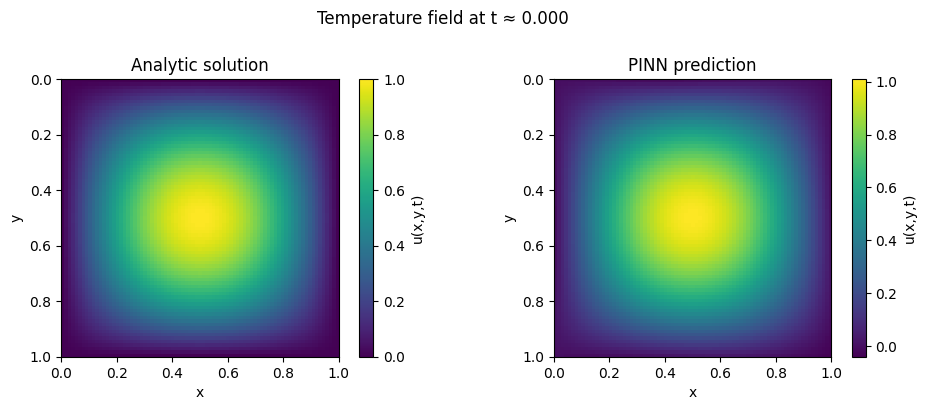

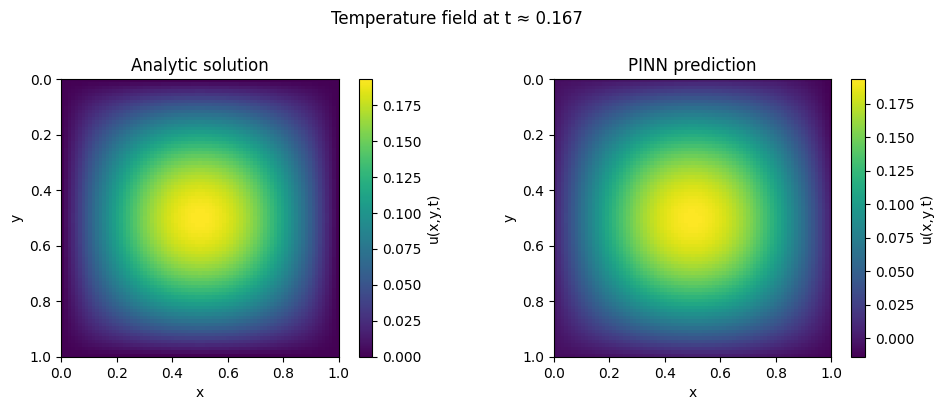

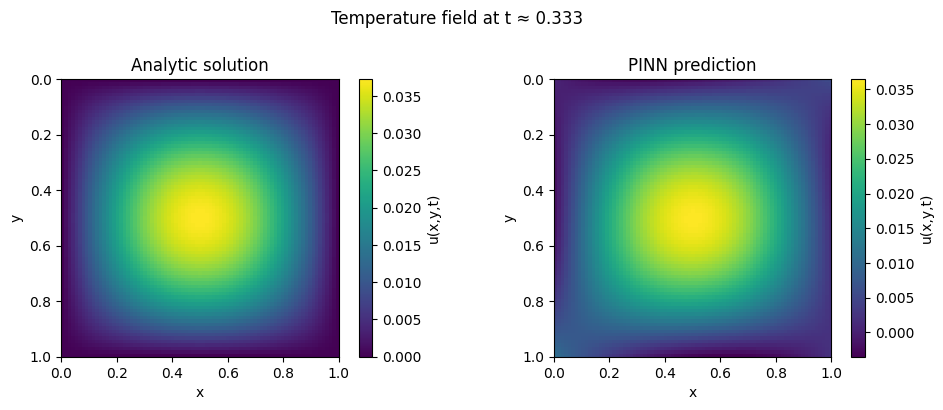

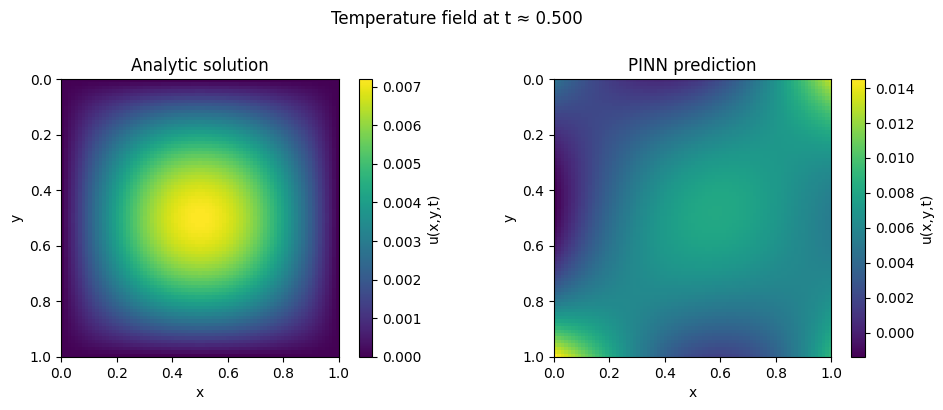

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ============================================================
# 0. General setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

# Spatial domain: unit square [0,1] x [0,1]
X_MIN, X_MAX = 0.0, 1.0
Y_MIN, Y_MAX = 0.0, 1.0

# Time window
T_MIN, T_MAX = 0.0, 0.5

# True physics (only used to generate synthetic data)
D_TRUE = 0.5                 # true diffusivity
m_mode, n_mode = 1, 1        # spatial mode indices
lambda_mode = np.pi**2 * (m_mode**2 + n_mode**2)  # 2*pi^2

print(f"True diffusivity D_true = {D_TRUE:.4f}")
print(f"Eigenvalue lambda = {lambda_mode:.4f}")


# ============================================================
# 1. Analytic solution (for data generation & validation)
# ============================================================
def analytic_solution(x, y, t, D=D_TRUE):
    """
    Exact solution for:
        u_t = D (u_xx + u_yy)
        u(x,y,0) = sin(pi x) sin(pi y)
        u=0 on boundary of unit square

    u(x,y,t) = exp(-D*lambda t) sin(pi x) sin(pi y)
    with lambda = pi^2(m^2+n^2) and m=n=1 here.
    """
    return np.exp(-D * lambda_mode * t) * \
           np.sin(m_mode * np.pi * x) * \
           np.sin(n_mode * np.pi * y)


# ============================================================
# 2. Generate synthetic noisy sensor data
# ============================================================
N_DATA = 500
NOISE_STD = 0.01

x_data_np = np.random.uniform(X_MIN, X_MAX, (N_DATA, 1))
y_data_np = np.random.uniform(Y_MIN, Y_MAX, (N_DATA, 1))
t_data_np = np.random.uniform(T_MIN, T_MAX, (N_DATA, 1))

u_clean_np = analytic_solution(x_data_np[:, 0], y_data_np[:, 0], t_data_np[:, 0])
u_noisy_np = u_clean_np + NOISE_STD * np.random.randn(N_DATA)

x_data = torch.tensor(x_data_np, dtype=torch.float32, device=DEVICE)
y_data = torch.tensor(y_data_np, dtype=torch.float32, device=DEVICE)
t_data = torch.tensor(t_data_np, dtype=torch.float32, device=DEVICE)
u_data = torch.tensor(u_noisy_np.reshape(-1, 1), dtype=torch.float32, device=DEVICE)

print(f"Generated {N_DATA} noisy sensor points.")


# ============================================================
# 3. PINN model u_theta(x,y,t)
# ============================================================
class MLP(nn.Module):
    """
    Simple fully-connected network mapping (x,y,t) -> u(x,y,t).
    """
    def __init__(self, in_dim=3, out_dim=1, width=64, depth=6):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth - 2):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)

        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, xyt):
        # xyt: (N,3) with columns [x,y,t]
        return self.net(xyt)


model = MLP().to(DEVICE)

# Diffusivity D as a learnable parameter (use log_D to keep D>0)
log_D = nn.Parameter(torch.log(torch.tensor([0.3], device=DEVICE)))
params = list(model.parameters()) + [log_D]


# ============================================================
# 4. Autograd helpers
# ============================================================
def gradients(u, xyt):
    """
    Compute gradients of u wrt [x,y,t].
    u: (N,1), xyt: (N,3) with requires_grad=True
    Returns: (N,3) with [du/dx, du/dy, du/dt]
    """
    return torch.autograd.grad(
        outputs=u,
        inputs=xyt,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]


# ============================================================
# 5. Sampling collocation, IC, BC points
# ============================================================
N_COL = 8000    # interior collocation points for PDE
N_IC  = 1000    # initial condition points at t=0
N_BC  = 1000    # boundary condition points on edges

def sample_interior(n):
    x = np.random.uniform(X_MIN, X_MAX, (n, 1))
    y = np.random.uniform(Y_MIN, Y_MAX, (n, 1))
    t = np.random.uniform(T_MIN, T_MAX, (n, 1))
    xyz = np.hstack([x, y, t])
    xyz = torch.tensor(xyz, dtype=torch.float32,
                       device=DEVICE, requires_grad=True)
    return xyz

def sample_ic(n):
    # t=0, u(x,y,0) = sin(pi x) sin(pi y)
    x = np.random.uniform(X_MIN, X_MAX, (n, 1))
    y = np.random.uniform(Y_MIN, Y_MAX, (n, 1))
    t = np.zeros_like(x)
    u0 = np.sin(np.pi * x) * np.sin(np.pi * y)
    xyt = np.hstack([x, y, t])
    xyt = torch.tensor(xyt, dtype=torch.float32, device=DEVICE)
    u0 = torch.tensor(u0, dtype=torch.float32, device=DEVICE)
    return xyt, u0

def sample_bc(n):
    # Sample points on the 4 edges: u=0
    n_side = n // 4

    # x = 0
    x0 = np.zeros((n_side, 1))
    y0 = np.random.uniform(Y_MIN, Y_MAX, (n_side, 1))
    t0 = np.random.uniform(T_MIN, T_MAX, (n_side, 1))

    # x = 1
    x1 = np.ones((n_side, 1))
    y1 = np.random.uniform(Y_MIN, Y_MAX, (n_side, 1))
    t1 = np.random.uniform(T_MIN, T_MAX, (n_side, 1))

    # y = 0
    x2 = np.random.uniform(X_MIN, X_MAX, (n_side, 1))
    y2 = np.zeros((n_side, 1))
    t2 = np.random.uniform(T_MIN, T_MAX, (n_side, 1))

    # y = 1
    x3 = np.random.uniform(X_MIN, X_MAX, (n_side, 1))
    y3 = np.ones((n_side, 1))
    t3 = np.random.uniform(T_MIN, T_MAX, (n_side, 1))

    x = np.vstack([x0, x1, x2, x3])
    y = np.vstack([y0, y1, y2, y3])
    t = np.vstack([t0, t1, t2, t3])

    xyt = np.hstack([x, y, t])
    xyt = torch.tensor(xyt, dtype=torch.float32, device=DEVICE)
    u_bc = torch.zeros((xyt.shape[0], 1), dtype=torch.float32, device=DEVICE)
    return xyt, u_bc


xyt_col = sample_interior(N_COL)       # PDE points
xyt_ic, u_ic = sample_ic(N_IC)         # IC points
xyt_bc, u_bc = sample_bc(N_BC)         # BC points


# ============================================================
# 6. Loss functions
# ============================================================
def pde_loss(model, xyt_col, D_val):
    """
    Physics loss: u_t = D (u_xx + u_yy).
    Residual r = u_t - D (u_xx + u_yy) -> minimize E[r^2].
    """
    # Ensure requires_grad=True
    if not xyt_col.requires_grad:
        xyt_col = xyt_col.clone().detach().requires_grad_(True)

    u = model(xyt_col)                  # (N,1)
    grads = gradients(u, xyt_col)       # (N,3)
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]
    u_t = grads[:, 2:2+1]

    # Second derivatives u_xx, u_yy
    grads_x = gradients(u_x, xyt_col)
    u_xx = grads_x[:, 0:1]

    grads_y = gradients(u_y, xyt_col)
    u_yy = grads_y[:, 1:2]

    laplace_u = u_xx + u_yy
    residual = u_t - D_val * laplace_u
    return torch.mean(residual**2)

def data_loss(model, x_data, y_data, t_data, u_data):
    """
    Data loss: fit noisy sensor measurements.
    """
    xyt = torch.cat([x_data, y_data, t_data], dim=1)
    u_pred = model(xyt)
    return torch.mean((u_pred - u_data)**2)

def ic_loss(model, xyt_ic, u_ic):
    """
    Initial condition loss: u(x,y,0) = sin(pi x) sin(pi y).
    """
    u_pred = model(xyt_ic)
    return torch.mean((u_pred - u_ic)**2)

def bc_loss(model, xyt_bc, u_bc):
    """
    Boundary condition loss: u=0 on all edges.
    """
    u_pred = model(xyt_bc)
    return torch.mean((u_pred - u_bc)**2)


# ============================================================
# 7. Training loop
# ============================================================
LR = 1e-3
EPOCHS = 6000

# Loss weights
W_DATA = 10.0
W_PDE  = 1.0
W_IC   = 1.0
W_BC   = 1.0

optimizer = torch.optim.Adam(params, lr=LR)

for epoch in range(1, EPOCHS + 1):
    optimizer.zero_grad()

    D_est = torch.exp(log_D)  # enforce D>0

    l_data = data_loss(model, x_data, y_data, t_data, u_data)
    l_pde  = pde_loss(model, xyt_col, D_est)
    l_ic   = ic_loss(model, xyt_ic, u_ic)
    l_bc   = bc_loss(model, xyt_bc, u_bc)

    loss = W_DATA * l_data + W_PDE * l_pde + W_IC * l_ic + W_BC * l_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:4d} | Total {loss.item():.3e} | "
            f"Data {l_data.item():.3e} | PDE {l_pde.item():.3e} | "
            f"IC {l_ic.item():.3e} | BC {l_bc.item():.3e} | "
            f"D_est ≈ {D_est.item():.4f}"
        )

D_learned = torch.exp(log_D).item()
print("\nTraining finished.")
print(f"True D = {D_TRUE:.4f}")
print(f"Learned D ≈ {D_learned:.4f}")


# ============================================================
# 8. Evaluate on a grid & visualize
# ============================================================
def evaluate_on_grid(model, nx=81, ny=81, nt=4):
    """
    Evaluate PINN on a 3D grid of (x,y,t) and compare with analytic.
    """
    x = np.linspace(X_MIN, X_MAX, nx)
    y = np.linspace(Y_MIN, Y_MAX, ny)
    t_slices = np.linspace(T_MIN, T_MAX, nt)

    X, Y = np.meshgrid(x, y)

    U_pred_list = []
    U_true_list = []

    for t_val in t_slices:
        t_grid = t_val * np.ones_like(X)
        xyt_np = np.stack([X.ravel(), Y.ravel(), t_grid.ravel()], axis=1)
        xyt_t = torch.tensor(xyt_np, dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            u_pred = model(xyt_t).cpu().numpy().reshape(ny, nx)
        u_true = analytic_solution(X, Y, t_val)

        U_pred_list.append(u_pred)
        U_true_list.append(u_true)

    return x, y, t_slices, U_pred_list, U_true_list

x_grid, y_grid, t_slices, U_pred_list, U_true_list = evaluate_on_grid(model)

# Plot a few time slices: PINN vs analytic
for idx, t_val in enumerate(t_slices):
    U_pred = U_pred_list[idx]
    U_true = U_true_list[idx]

    plt.figure(figsize=(10,4))
    plt.suptitle(f"Temperature field at t ≈ {t_val:.3f}")

    plt.subplot(1,2,1)
    plt.imshow(U_true, extent=[X_MIN, X_MAX, Y_MAX, Y_MIN],
               origin="upper", aspect="equal")
    plt.title("Analytic solution")
    plt.colorbar(label="u(x,y,t)")
    plt.xlabel("x"); plt.ylabel("y")

    plt.subplot(1,2,2)
    plt.imshow(U_pred, extent=[X_MIN, X_MAX, Y_MAX, Y_MIN],
               origin="upper", aspect="equal")
    plt.title("PINN prediction")
    plt.colorbar(label="u(x,y,t)")
    plt.xlabel("x"); plt.ylabel("y")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
